In [1]:
##############################
#OI HS Analysis              #
#Maintainer: Christopher Chan#
#Date: 2024-09-08            #
#Version: 0.1.7              #
##############################

import os
import pathlib
import matplotlib

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import FancyArrowPatch

data_feature = pathlib.Path("../data/04_feature")
data_output = pathlib.Path("../data/07_model_output")
fig_output = pathlib.Path("../docs/figures")

with open(f"{data_feature}/hash_r1_score.csv") as round_1:
    r1_df = pd.read_csv(round_1, sep = ",")
    r1_df.columns = [f"{col}_r1" if col not in ["Issue", "Issue_cat"] else col for col in r1_df.columns]

with open(f"{data_feature}/hash_r2_score.csv") as round_2:
    r2_df = pd.read_csv(round_2, sep = ",")
    r2_df.columns = [f"{col}_r2" if col not in ["Issue", "Issue_cat"] else col for col in r2_df.columns]

HS_combine = pd.merge(r1_df, r2_df, on=["Issue", "Issue_cat"], how="inner", suffixes=["_r1", "_r2"])
rank_cols = HS_combine.filter(regex="(?i)^rank", axis = 1).columns
HS_combine.drop(rank_cols, axis = 1, inplace = True)

In [2]:
misc_cols = HS_combine.filter(regex="rank|score").columns
HS_justScore = HS_combine.drop(columns = misc_cols, axis = 1)
HS_justScore = HS_justScore.drop(columns = ["Unnamed: 0_r1", "Unnamed: 0_r2"], axis = 1)

HS_justScore.sample(n = 8)

Issue  \
13  Interactions of global catastrophic risks with...   
26  Locked in climate tipping point impacts underm...   
11       Crisis, gridlock, and accelerating fragility   
20  Geoengineering to prevent climate tipping poin...   
34  Change to a superrotating state of the atmosphere   
6   The risk of sudden massive crop losses due to ...   
25                       Loss of primary productivity   
14  Recovery of global communication systems from ...   

                        Issue_cat  492e4b_r1  22338c_r1  9f1eb6_r1  04545f_r1  \
13                  Systemic Risk        644        874        347        978   
26  Climate Environment & Ecology        598        864        250        888   
11          Government & Politics        679        931        391        578   
20  Climate Environment & Ecology        665        784        390        703   
34  Climate Environment & Ecology        490        485         40          5   
6                     Biosecurity        747        892        360        608   
25  Climate Environment & Ecology        764        834        190        723   
14                  Systemic Risk        700        867        389         88   

    6d4470_r1  ed22ef_r1  540a7a_r1  708920_r1  ...  3bf1fb_r2  540a7a_r2  \
13      500.0        767        896        888  ...        700        150   
26      230.7        556        625        339  ...        159        444   
11      570.1        711        690        587  ...        570        385   
20      649.0        400        500        405  ...        320        290   
34      750.0        445        540        555  ...        420        100   
6       400.0        800        505        643  ...        300        380   
25      907.1        588        230        641  ...        104        101   
14      700.0        554        325        788  ...        650        310   

    3ee680_r2  22338c_r2  9f1eb6_r2  ed22ef_r2  d9bf00_r2  492e4b_r2  \
13         11        171        180        500        420        650   
26        345        411        305        499        305        545   
11        411        616        190        400        830        598   
20        856        720        420        400        601        547   
34        814         90         50        250        200        135   
6         222        290        480        599        600        410   
25        124        156        155        496        120        299   
14        950        390        620        500        502        376   

    2a8c4a_r2  3b7706_r2  
13        727        735  
26        858        779  
11        385        788  
20        733        733  
34        593        400  
6         838        670  
25        325        868  
14        496        585  

[8 rows x 48 columns]

In [3]:
HS_justScore.columns

Index(['Issue', 'Issue_cat', '492e4b_r1', '22338c_r1', '9f1eb6_r1',
       '04545f_r1', '6d4470_r1', 'ed22ef_r1', '540a7a_r1', '708920_r1',
       '9a2d12_r1', 'cdefc7_r1', 'd9bf00_r1', '3ee680_r1', 'e5ed2f_r1',
       '029745_r1', 'b59cd1_r1', '3bf1fb_r1', '04c88f_r1', 'e96af1_r1',
       '4f4fcd_r1', '53465a_r1', '3b7706_r1', '874d58_r1', 'fb235a_r1',
       '79bd39_r1', 'd2282d_r1', '7b9161_r1', 'fbb58e_r1', '2a8c4a_r1',
       '708920_r2', 'e96af1_r2', 'e5ed2f_r2', 'd6c710_r2', '874d58_r2',
       '9a2d12_r2', 'fbb58e_r2', 'd2282d_r2', '3bf1fb_r2', '540a7a_r2',
       '3ee680_r2', '22338c_r2', '9f1eb6_r2', 'ed22ef_r2', 'd9bf00_r2',
       '492e4b_r2', '2a8c4a_r2', '3b7706_r2'],
      dtype='object')

In [4]:
justScore_Ldf = pd.melt(HS_justScore, id_vars=["Issue", "Issue_cat"], var_name='Participant', value_name='Score')
justScore_Ldf["HS_round"] = justScore_Ldf["Participant"].str.extract('(_r\d)').replace({'_r1': 1, '_r2': 2})
justScore_Ldf["Participant"] = justScore_Ldf["Participant"].str.replace('(_r\d)', '', regex=True)
print(justScore_Ldf.loc[:, ['Score', 'HS_round']].groupby('HS_round').describe())

justScore_Ldf

          Score                                                            
          count        mean         std  min     25%    50%     75%     max
HS_round                                                                   
1         980.0  551.789898  251.463475  1.0  368.75  580.0  750.75   998.0
2         630.0  513.290476  254.206618  1.0  310.00  515.0  718.25  1000.0


/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2774313551.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  justScore_Ldf["HS_round"] = justScore_Ldf["Participant"].str.extract('(_r\d)').replace({'_r1': 1, '_r2': 2})


Issue  \
0     Risk Accelerator: Integration of AI in Nuclear...   
1     Cracks in the foundation: critical transitions...   
2     Supercharged Surveillance States merged with p...   
3     Cascading loss of food system complexity causi...   
4     Status-Quo Path-Dependence by Elites merged wi...   
...                                                 ...   
1605  Use of inadequate tools for climate risk asses...   
1606                            State Capacity Deficits   
1607  Combination of natural and technological disas...   
1608  Catastrophic impacts from satellite megaconste...   
1609  Change to a superrotating state of the atmosphere   

                          Issue_cat Participant  Score  HS_round  
0                   Nuclear Weapons      492e4b  650.0         1  
1     Climate Environment & Ecology      492e4b  855.0         1  
2             Government & Politics      492e4b  730.0         1  
3                     Food Security      492e4b  942.0         1  
4                           Society      492e4b  400.0         1  
...                             ...         ...    ...       ...  
1605  Climate Environment & Ecology      3b7706  788.0         2  
1606          Government & Politics      3b7706  863.0         2  
1607                  Systemic Risk      3b7706  589.0         2  
1608                          Space      3b7706  888.0         2  
1609  Climate Environment & Ecology      3b7706  400.0         2  

[1610 rows x 5 columns]

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t


Modified WLS results
                            WLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.112
Model:                            WLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     5.557
Date:                Mon, 09 Sep 2024   Prob (F-statistic):             0.0229
Time:                        10:05:34   Log-Likelihood:                -313.01
No. Observations:                  46   AIC:                             630.0
Df Residuals:                      44   BIC:                             633.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        465.8960     98.0

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")



Modified WLS results
                            WLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.07890
Date:                Mon, 09 Sep 2024   Prob (F-statistic):              0.779
Time:                        10:05:35   Log-Likelihood:                -630.88
No. Observations:                  92   AIC:                             1266.
Df Residuals:                      90   BIC:                             1271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        607.0079     74.6

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t


Modified WLS results
                            WLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.029
Model:                            WLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.650
Date:                Mon, 09 Sep 2024   Prob (F-statistic):              0.107
Time:                        10:05:35   Log-Likelihood:                -642.98
No. Observations:                  92   AIC:                             1290.
Df Residuals:                      90   BIC:                             1295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        407.3175     83.3

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")
/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/2670325617.py:57: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


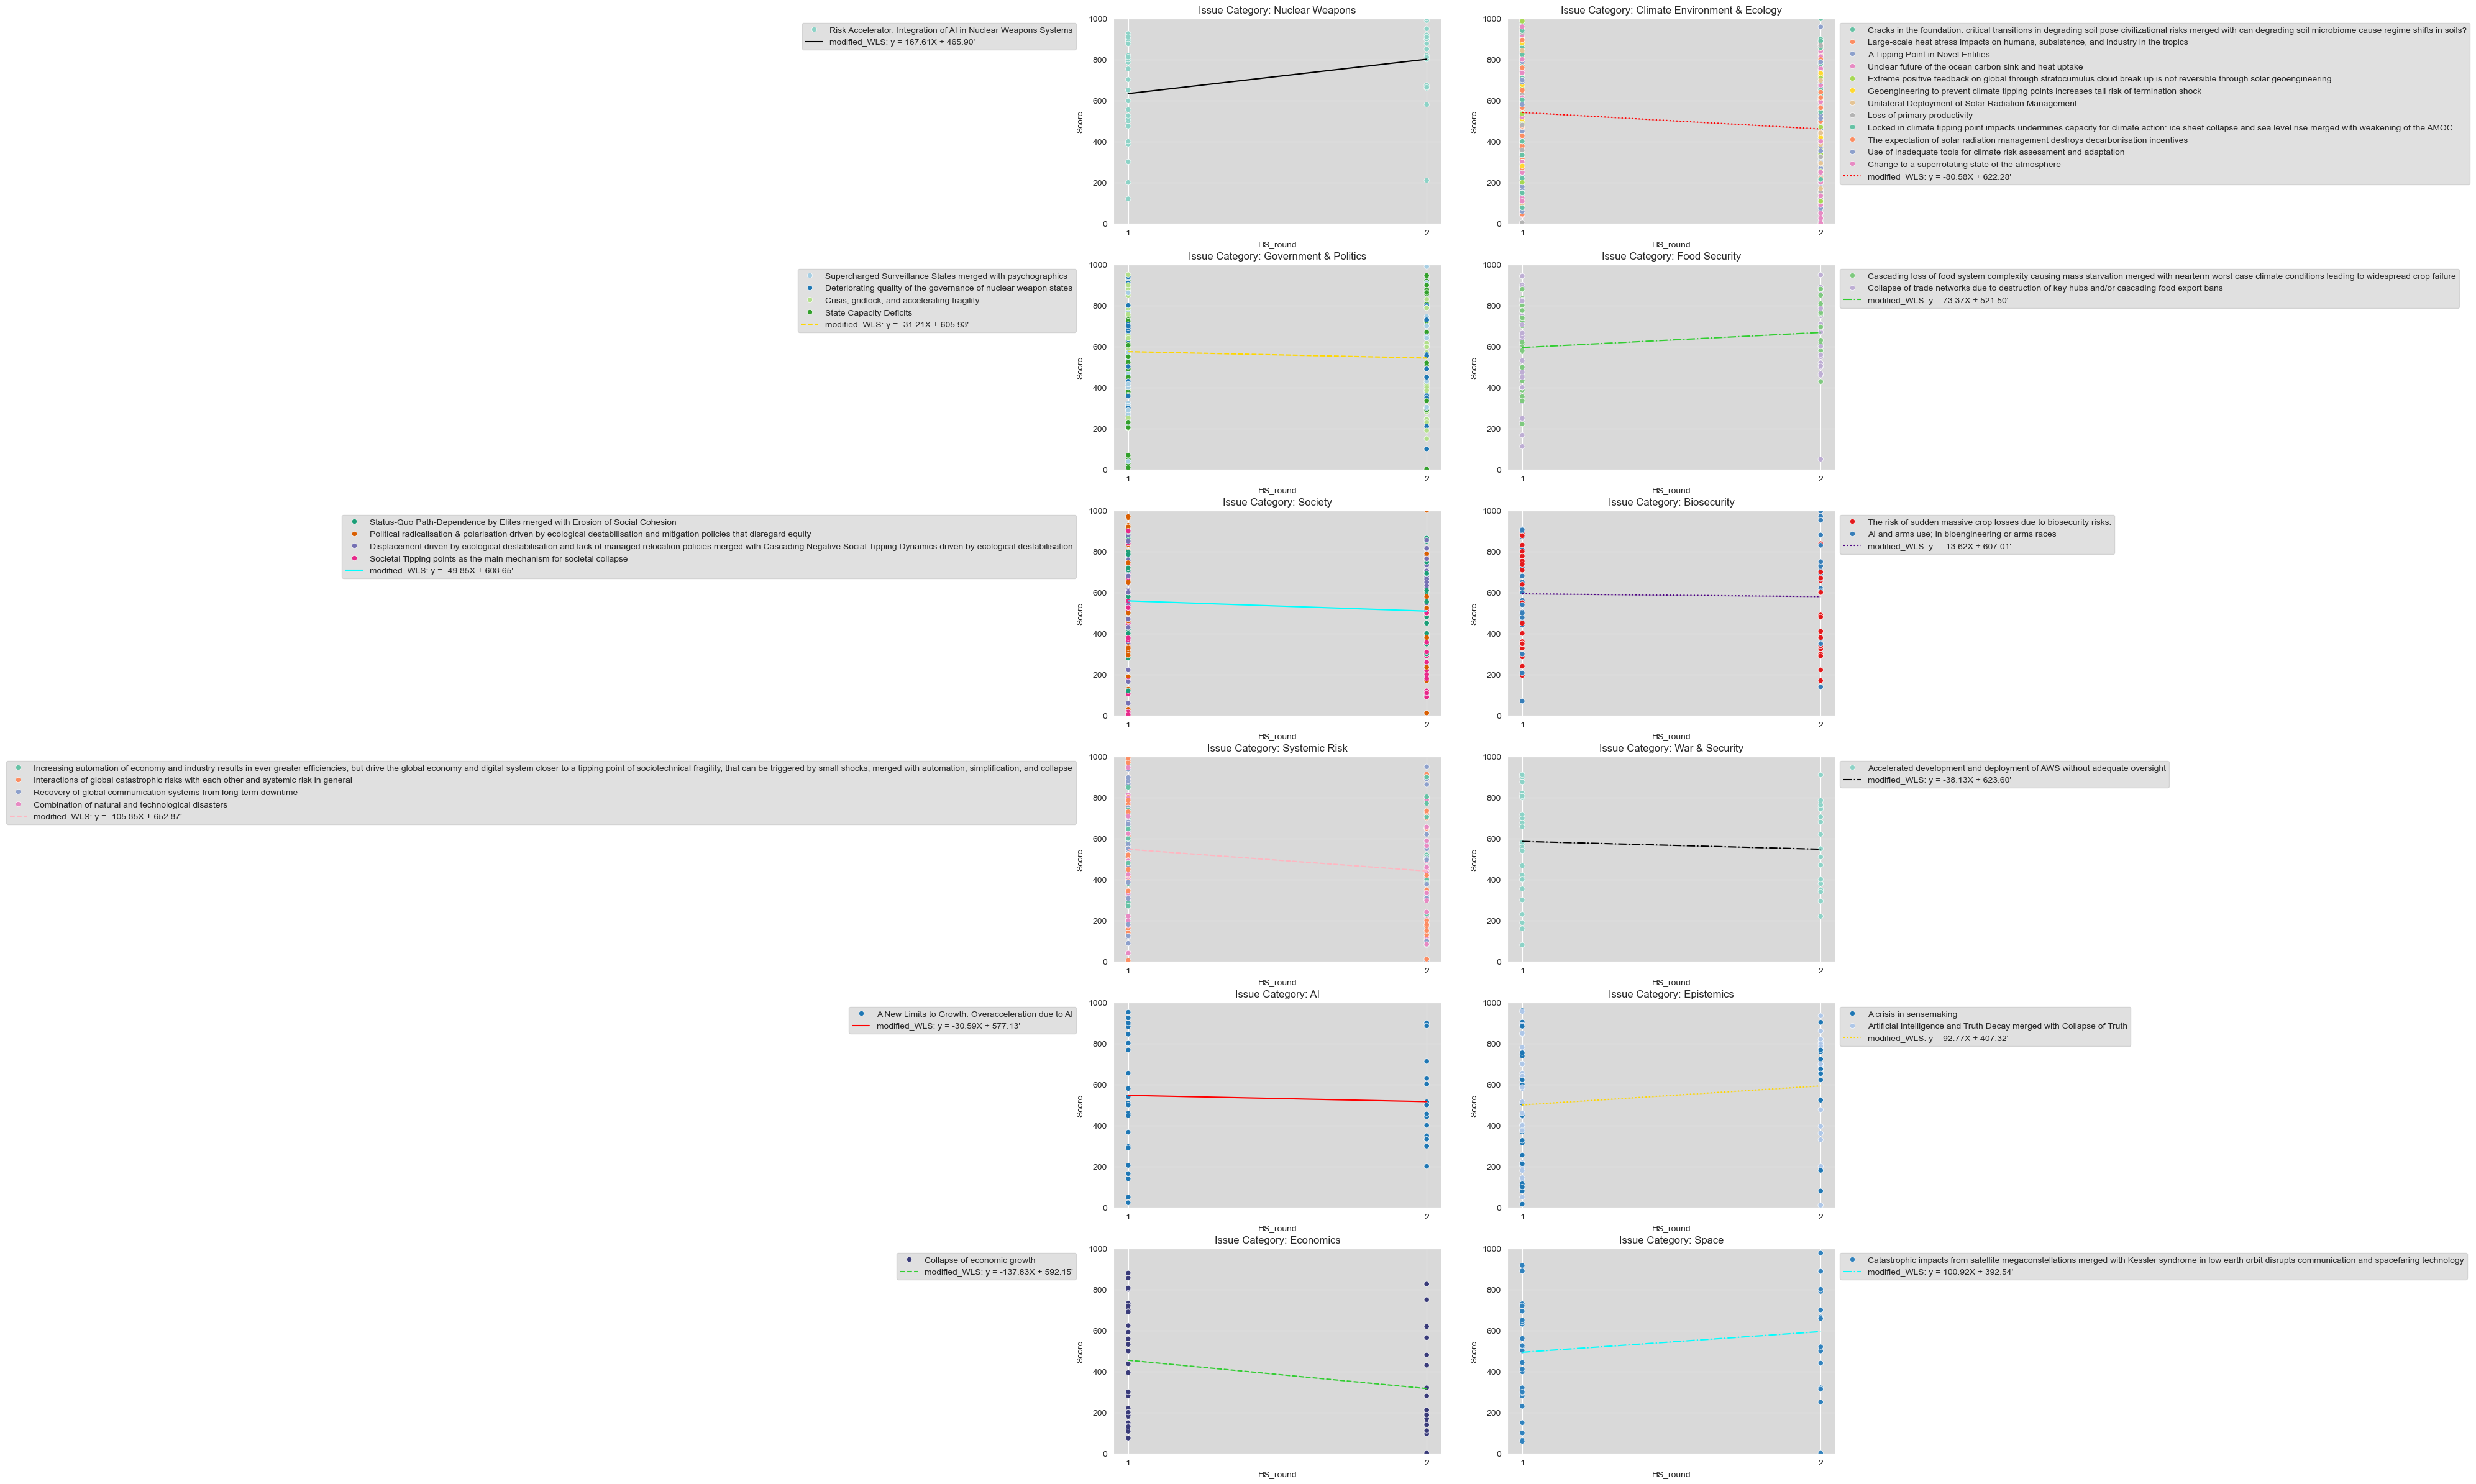

In [5]:
sns.set_style('darkgrid', {'axes.facecolor': '.85'})

fig, ax = plt.subplots(6, 2, figsize=(15, 30))

axes = ax.flatten()

r1_exp = []
r2_exp = []


for idx, cat in enumerate(justScore_Ldf['Issue_cat'].unique()):
    palette_ls = ['Set3', 'Set2', 'Paired', 'Accent', 'Dark2', 'Set1',
                  'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
    linestyle_ls = ['solid', 'dotted', 'dashed', 'dashdot', 'solid',
                    'dotted', 'dashed', 'dashdot', 'solid', 'dotted',
                    'dashed', 'dashdot']
    colour_ls = ['black', 'red', 'gold', 'limegreen', 'cyan', 'indigo',
                 'lightpink', 'black', 'red', 'gold', 'limegreen', 'cyan']

    justScore_cat = justScore_Ldf[justScore_Ldf['Issue_cat'] == cat]

    # Inverse WLS that uses variance as weights
    y = justScore_cat['Score']
    x = justScore_cat['HS_round']
    X_sm = sm.add_constant(x)
    variance = justScore_cat.groupby('HS_round')['Score'].var()
    in_wt = justScore_cat['HS_round'].map(variance)

    # Create model, fit, and print results
    inv_WLS = sm.WLS(y, X_sm, weights = in_wt)
    res_inv = inv_WLS.fit()
    inv_ypred = res_inv.predict()
    print("\nModified WLS results")
    print(res_inv.summary())

    # Fill DataFrame
    r1_exp.append(inv_ypred[0])
    r2_exp.append(inv_ypred[-1])
    
    splot = sns.scatterplot(justScore_cat, x='HS_round', y='Score',
                            hue='Issue', ax=axes[idx], palette=palette_ls[idx])
    WLSplot = sns.lineplot(justScore_cat, x='HS_round', y=inv_ypred,
                           ax=axes[idx], linestyle=linestyle_ls[idx], color=colour_ls[idx],
                           label=f"modified_WLS: y = {res_inv.params[1]:.2f}X + {res_inv.params[0]:.2f}'")

    axes[idx].set_title(f"Issue Category: {cat}")
    axes[idx].set_xticks([1, 2])
    axes[idx].set_ylim(1-1, 1000)

    if idx % 2 == 0:
        # Left side subplots
        axes[idx].legend(bbox_to_anchor = (-0.1, 1), ncol=1)
    else:
        # Right side subplots
        axes[idx].legend(bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout()
plt.savefig(f"{fig_output}/WLSissueCat_subplots.png")
plt.show()

# DataFrame to collect inv_WLS ypred expected values
WLS_expDF = pd.DataFrame({
    "Issue_cat": justScore_Ldf["Issue_cat"].unique(),
    "round_1": r1_exp,
    "round_2": r2_exp
})

In [6]:
justScore_Ldf['Issue_cat'].unique()

array(['Nuclear Weapons', 'Climate Environment & Ecology',
       'Government & Politics', 'Food Security', 'Society', 'Biosecurity',
       'Systemic Risk', 'War & Security', 'AI', 'Epistemics', 'Economics',
       'Space'], dtype=object)

In [7]:
WLS_expDF_L = pd.melt(WLS_expDF, id_vars="Issue_cat", value_vars=["round_1", "round_2"], var_name="HS_round", value_name="Expected_Score")

WLS_expDF_L

Issue_cat HS_round  Expected_Score
0                 Nuclear Weapons  round_1      633.503571
1   Climate Environment & Ecology  round_1      541.704762
2           Government & Politics  round_1      574.721429
3                   Food Security  round_1      594.876786
4                         Society  round_1      558.805357
5                     Biosecurity  round_1      593.392857
6                   Systemic Risk  round_1      547.017857
7                  War & Security  round_1      585.464286
8                              AI  round_1      546.535714
9                      Epistemics  round_1      500.089286
10                      Economics  round_1      454.325000
11                          Space  round_1      493.464286
12                Nuclear Weapons  round_2      801.111111
13  Climate Environment & Ecology  round_2      461.129630
14          Government & Politics  round_2      543.513889
15                  Food Security  round_2      668.250000
16                        Society  round_2      508.958333
17                    Biosecurity  round_2      579.777778
18                  Systemic Risk  round_2      441.166667
19                 War & Security  round_2      547.333333
20                             AI  round_2      515.944444
21                     Epistemics  round_2      592.861111
22                      Economics  round_2      316.500000
23                          Space  round_2      594.388889

/var/folders/tz/q11qj2t518z2mqsm9xzdw7r00000gn/T/ipykernel_7547/604860363.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  lolli = sns.scatterplot(WLS_expDF_L, x="Expected_Score", y="Issue_cat",


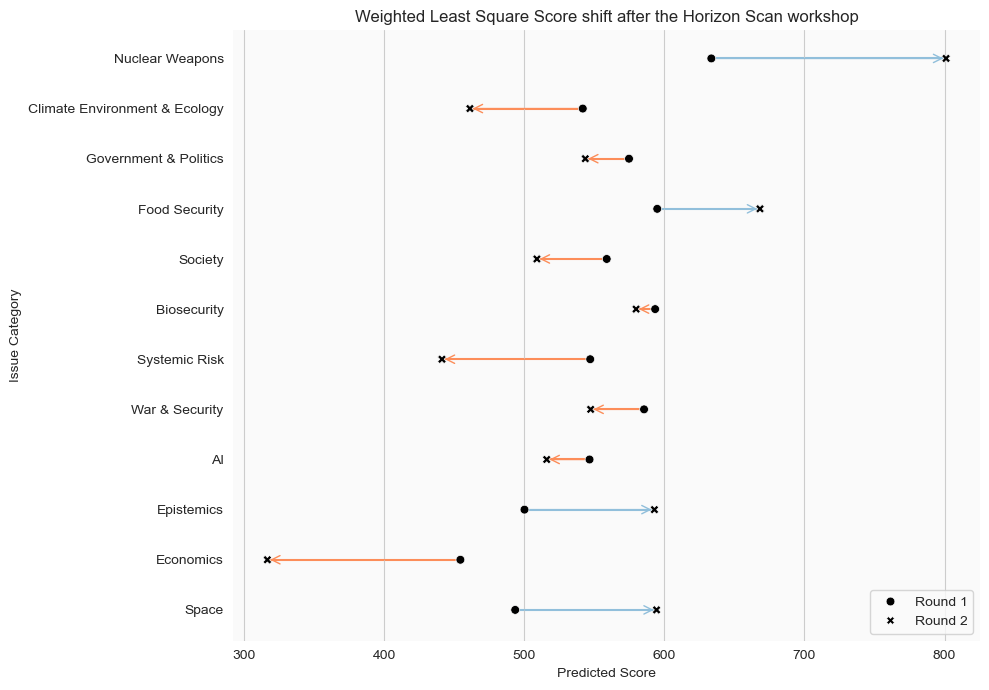

In [8]:
# Lollipop chart
sns.set_style('whitegrid', {'axes.facecolor': '0.98'})

fig, ax = plt.subplots(figsize = (10, 7))

#lolli = sns.scatterplot(WLS_expDF_L, x="Expected_Score", y="Issue_cat",
#                        hue="HS_round", palette="Set2")

for idx, cat in enumerate(WLS_expDF_L["Issue_cat"].unique()):
    temp_df = WLS_expDF_L[WLS_expDF_L["Issue_cat"] == cat]

    r1_score = temp_df[temp_df["HS_round"] == "round_1"]["Expected_Score"].values[0]
    r2_score = temp_df[temp_df["HS_round"] == "round_2"]["Expected_Score"].values[0]

    if r2_score > r1_score:
        cane_col = "#91bfdb"
        plt.gca().add_patch(FancyArrowPatch((r1_score, idx), (r2_score, idx),
                                       arrowstyle='->', color='#91bfdb', mutation_scale=15))
    else:
        cane_col = "#fc8d59"        
        plt.gca().add_patch(FancyArrowPatch((r2_score, idx), (r1_score, idx),
                                       arrowstyle='<-', color='#fc8d59', mutation_scale=15))


    sns.lineplot(temp_df, x="Expected_Score", y="Issue_cat",
                 color=cane_col, zorder=0)

lolli = sns.scatterplot(WLS_expDF_L, x="Expected_Score", y="Issue_cat",
                        color="#000000", palette="Set2", zorder=1,
                        style="HS_round", s=40)


lolli.yaxis.grid(False)
handles, _ = lolli.get_legend_handles_labels()
new_handles = ['Round 1', 'Round 2']
lolli.legend(handles, new_handles, loc="lower right")
#lolli.set_xlim(1, 1000)
plt.xticks(list(range(300, 900, 100)))

sns.despine(left=True, bottom=True)
plt.ylabel("Issue Category")
plt.xlabel("Predicted Score")
plt.title("Weighted Least Square Score shift after the Horizon Scan workshop")

plt.tight_layout()
plt.savefig(f"{fig_output}/Deliberation_lolli.png")
plt.show()